# Pairs Trading

Pairs trading relies on cointegration. Cointegration is a statistical method to test the stationarity between two-time series. Stationarity describes a time series that has no trend, a constant variance through time, and no seasonality. The “pair” is a linear combination of both stocks: one you buy and one you sell.

Warning:
1. Pairs trading assumes stock prices are cointegrated. Technically, that means that a linear combination of prices varies around a stable mean on the same distribution. In practice, traders use Augmented Dickey-Fuller tests, Hurst exponents, and Kalman filters to test for cointegration.

2. Looping through pairs to find p-values increases the likelihood of incorrectly finding a significant p-value when many tests are run (a false positive). Start with the economic rationale of why two stocks should be cointegrated. In practice, traders pick a handful of stocks with economic links and test those.

In [3]:
#Pairs trading exploits periodic breakdowns in economic relationships.
import numpy as np
import pandas as pd

import statsmodels.api as sm
from statsmodels.tsa.stattools import coint
from statsmodels.regression.rolling import RollingOLS

import yfinance as yf
import seaborn
import matplotlib.pyplot as plt

In [4]:
symbol_list = ['META', 'AMZN', 'AAPL', 'NFLX', 'GOOG',"LMT"]
data = yf.download(
    symbol_list, 
    start='2014-01-01', 
    end='2015-01-01'
)['Adj Close']

[*********************100%***********************]  6 of 6 completed


In [5]:
# loop through the different combinations of pairs to test if they’re co-integrated
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

This function loops through a list of securities and tests for cointegration between all pairs. It returns a cointegration test score matrix, a p-value matrix, and any pairs for which the p-value was less than 0.05.

In [6]:
scores, pvalues, pairs = find_cointegrated_pairs(data)

<AxesSubplot:>

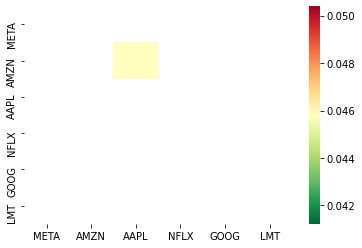

In [7]:
seaborn.heatmap(
    pvalues, 
    xticklabels=symbol_list, 
    yticklabels=symbol_list, 
    cmap='RdYlGn_r', 
    mask = (pvalues >= 0.05)
)

It looks like AMZN and AAPL are co-integrated!

Step 3: Model the spread
Now that you found a pair, run a linear regression using statsmodels and model the spread as a linear combination of AAPL and AMZN. b is the beta coefficient from the linear regression, otherwise known as the “hedge ratio.”

In [8]:
S1 = data.AMZN
S2 = data.AAPL

S1 = sm.add_constant(S1)
results = sm.OLS(S2, S1).fit()
S1 = S1.AMZN
b = results.params['AMZN']
spread = S2 - b * S1

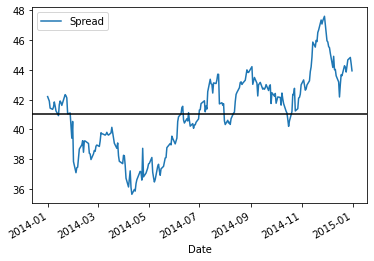

In [9]:
spread.plot()
plt.axhline(spread.mean(), color='black')
plt.legend(['Spread']);

Step 4: Build a simple trading strategy
You buy the spread when it gets “too low” and sell the spread when it gets “too high.” But what is too low and too high? Use the z-score to normalize the spread and use it as the trade signal. If you buy the pair, you buy AAPL and sell b shares of AMZN. If you sell the pair, you sell AAPL and buy b shares of AMZN.

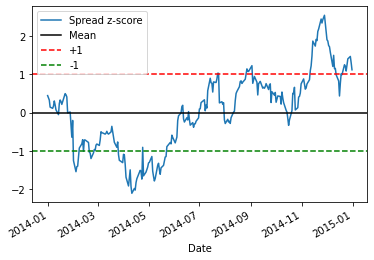

In [10]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

zscore(spread).plot()
plt.axhline(zscore(spread).mean(), color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Spread z-score', 'Mean', '+1', '-1']);

In [11]:
# Create a DataFrmae with the signal and position size in the pair
trades = pd.concat([zscore(spread), S2 - b * S1], axis=1)
trades.columns = ["signal", "position"]

# Add a long and short position at the z-score levels
trades["side"] = 0.0
trades.loc[trades.signal <= -1, "side"] = 1
trades.loc[trades.signal >= 1, "side"] = -1

First, create a DataFrame with the signal and the position in the pair. Then add a column to the DataFrame and populate it with a 1 when the signal is less than or equal to -1 and -1 when the signal is greater than or equal to 1.

Finally, plot the equity curve.

<AxesSubplot:xlabel='Date'>

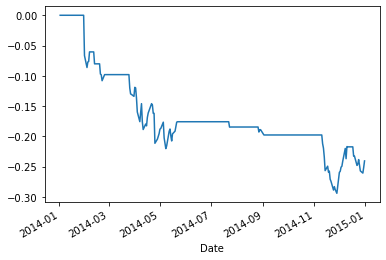

In [12]:
returns = trades.position.pct_change() * trades.side
returns.cumsum().plot()

This pair is consistently losing money. This could mean a few things. First, there is no linear combination that is stationary and we have a false positive. Or, there is no real economic relationship that drives the two stocks. Or, there is a linear combination and there is an economic relationship, but the relationship continued to break down during the frame you used.

# Kalman filter

The Kalman filter is useful for computing the moving average or for smoothing out estimates of other quantities. For example, if you already computed the moving Sharpe ratio, you can smooth it using a Kalman filter. At each time step, the algorithm estimates the current state of the system using the transition matrix, takes in new measurements, then updates the estimated current state.

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

from pykalman import KalmanFilter
# from openbb_terminal.sdk import openbb

# data = openbb.stocks.load("LMT", start_date="2013-01-01", end_date="2015-01-01")


symbol_list = ["LMT"]
data = yf.download(
    symbol_list, 
    start='2013-01-01', 
    end='2015-01-01'
)['Adj Close']

[*********************100%***********************]  1 of 1 completed


In [18]:
kf = KalmanFilter(
    transition_matrices = [1],
    observation_matrices = [1],
    initial_state_mean = 0,
    initial_state_covariance = 1,
    observation_covariance=1,
    transition_covariance=0.01
)
# The transition matrix tells the algorithm how the system evolves from one state to another. The observation matrix tracks the next measurement given the predicted next state. The initial mean and covariance are the initial estimates of the state and error and the covariances measure the noise in the evolution of the algorithm. In more complex examples, you can calibrate these inputs to give a better first estimate.

# After you define the inputs for the Kalman filter algorithm, use it to filter the prices and find the “true” average.



Text(0, 0.5, 'Price')

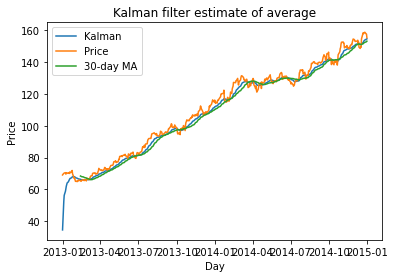

In [23]:
#data = prices
state_means, _ = kf.filter(data.values)
state_means = pd.Series(state_means.flatten(), index=data.index)

mean30 = data.rolling(window=30).mean()

plt.plot(state_means)
plt.plot(data)
plt.plot(mean30)
plt.title('Kalman filter estimate of average')
plt.legend(['Kalman', 'Price', '30-day MA'])
plt.xlabel('Day')
plt.ylabel('Price')

Notice the Kalman filter starts with an estimate that is far away from the prices. That’s because we seeded the algorithm with a matrix of 1s. Within only a few time steps it corrects and more accurately models the price series.

Zoom in on the last 200 days to get a closer look.

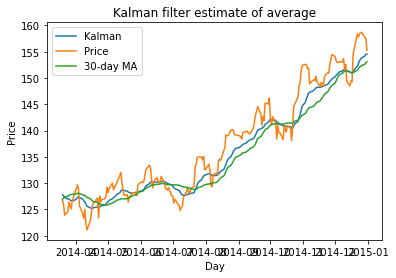

In [25]:
plt.plot(state_means[-200:])
plt.plot(data[-200:])
plt.plot(mean30[-200:])
plt.title('Kalman filter estimate of average')
plt.legend(['Kalman', 'Price', '30-day MA'])
plt.xlabel('Day')
plt.ylabel('Price');

The Kalman filter works well on noisy data and trains quickly without labeled data (it’s an unsupervised learning algorithm). Use it to smooth rolling metrics on noisy stock price data.

# Hurst Exponent for Strategy Selection

The Hurst exponent is a measure of the long-term memory of a time series. It quantifies the tendency of a time series to revert to its mean or cluster in one direction. The Hurst exponent shows if a time series behaves in a random, trending, or mean-reverting way. It captures the speed autocorrelation decrease as the lag increases.
---

The Hurst exponent ranges between 0 and 1.

If the Hurst exponent is below 0.5, the market is mean reverting. Reversal strategies win in these markets.

If the Hurst exponent of 0.5 means the market is random. In this case, a trading strategy that relies on the market direction will lose money.

If the Hurst exponent is above 0.5 the market is trending. Markets with a high Hurst exponent are perfect for trend-following strategies.

Unfortunately, most traders will trade the same strategy through all markets. Use the Hurst exponent to pick the right strategy for the market.

[*********************100%***********************]  1 of 1 completed


<AxesSubplot:title={'center':'S&P 500'}, xlabel='Date'>

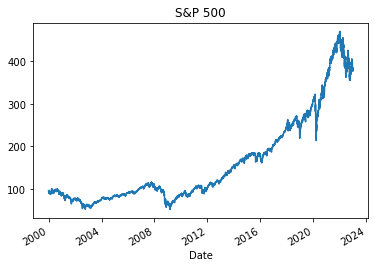

In [26]:
import pandas as pd
import numpy as np

#from openbb_terminal.sdk import openbb
#df = openbb.stocks.load("^GSPC", start_date="2000-01-01", end_date="2019-12-31")["Adj Close"]

symbol_list = ["SPY"]
df = yf.download(
    symbol_list, 
    start='2000-01-01', 
    end='2023-01-01'
)['Adj Close']
df.plot(title="S&P 500")

The trending and mean reverting periods are obvious when you inspect them visually. Though you can’t visually interpret every chart at every  time frame.

But you can use the Hurst exponent.        

Step 2: Calculate the Hurst exponent

In [27]:
def get_hurst_exponent(ts, max_lag=20):
    lags = range(2, max_lag)
    tau = [np.std(np.subtract(ts[lag:], ts[:-lag])) for lag in lags]
    
    return np.polyfit(np.log(lags), np.log(tau), 1)[0]

The Hurst exponent uses lags to measure the long-term memory of the time series. For each lag in the range, calculate the standard deviation of the differenced series. Then calculate the slope of the log lags versus the standard deviations. You can do this by returning the first value from NumPy’s polyfit function which fits a first-degree polynomial function.

Step 3: Determine the type of market

In [28]:
for lag in [20, 100, 250, 500, 1000]:
    hurst_exp = get_hurst_exponent(df.values, lag)
    print(f"{lag} lags: {hurst_exp:.4f}")

20 lags: 0.4774
100 lags: 0.4297
250 lags: 0.4788
500 lags: 0.4960
1000 lags: 0.4856


This will print the Hurst exponent at different lags. Over the entire time series, the S&P 500 is close to random. In the shorter lags, there is evidence of mean reversion.

Now, zoom in on a specific period in time.

In [29]:
shorter_series = df.loc["2005":"2007"].values
for lag in [20, 100, 250, 500]:
    hurst_exp = get_hurst_exponent(shorter_series, lag)
    print(f"{lag} lags: {hurst_exp:.4f}")

20 lags: 0.3957
100 lags: 0.3184
250 lags: 0.2549
500 lags: 0.1312


Just as the Great Financial Crisis hit, the S&P 500 was mean reverting. In fact, with 500 lags, the Hurst exponent is close to 0.13. (Hurst exponent is below 0.5, the market is mean reverting.)